In [2]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy.io import wavfile
import numpy as np
import seaborn as sns
from scipy.spatial import distance
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, InputLayer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from random import randrange
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model 
import tensorflow.keras.utils as ku 
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split

nperseg = 256
maxlen = 512

In [1]:
# !wget http://206.12.93.90:8080/LJSpeech-1.1/LJSpeech-1.1.tar.gz
# !tar -xzvf  LJSpeech-1.1.tar.gz 2> /dev/null
# !rm LJSpeech-1.1.tar.gz


In [3]:
# The methods below are used for processing text.
vocabulary_to_index = {'_':0}
index_to_vocabulary = {0:'_'}
for c in range(ord('a'), ord('z')+1):
        vocabulary_to_index[chr(c)] = len(vocabulary_to_index)
        index_to_vocabulary[len(index_to_vocabulary)] = chr(c)

def prepreocess_text(text):
    text = text.lower().replace(" ", "_")    
    out_text = ''
    out_indexes = []
    for c in text:
        last = ''
        if len(out_text) != 0:
            last = out_text[-1]        
        if c in vocabulary_to_index and last!= c:
            out_text += c
            out_indexes.append(vocabulary_to_index[c])
    return out_text, out_indexes

def get_labels_baseline(time_len, clusters):
    labels = []
    w = int(time_len / len(clusters)) 
    for c in clusters:
        labels = labels + [c] * int(w)
    while len(labels) < time_len:
        labels.append(labels[-1])
    return labels[0:time_len], w
    
    

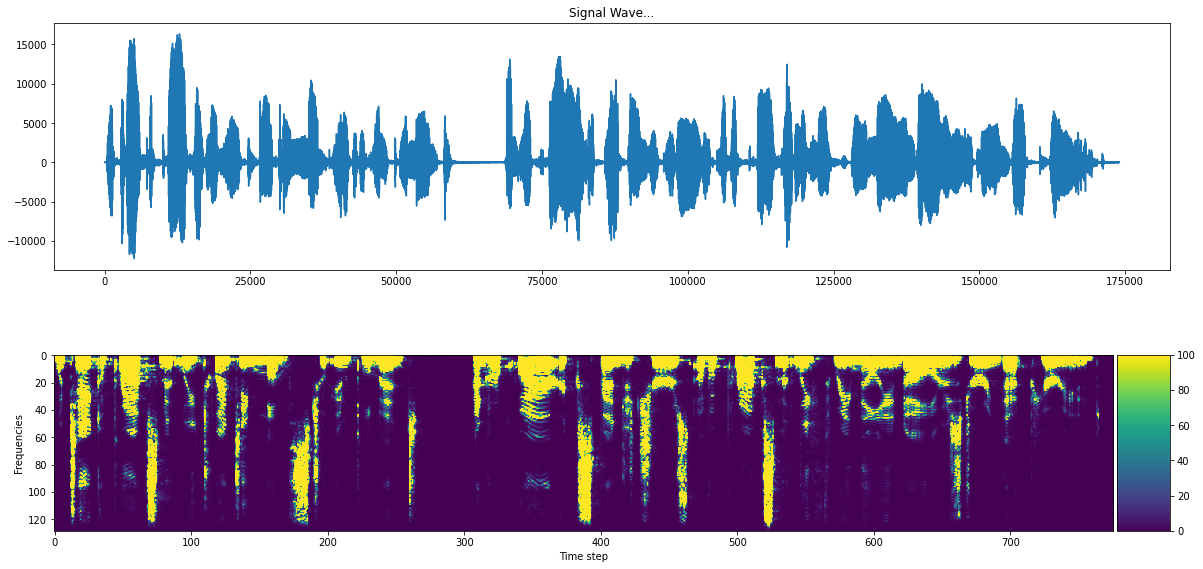

In [ ]:
sample_rate, samples = wavfile.read('data/LJ050-0222.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=nperseg)
spectrogram = np.transpose(spectrogram)

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(2,1,1)
plt.title("Signal Wave...")
plt.plot(samples)

ax = plt.subplot(2,1,2)
im = ax.imshow(np.transpose(spectrogram), vmax=100)
# plt.title('Pearson correlation')
plt.xlabel('Time step')
plt.ylabel('Frequencies')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax = cax)
plt.show()



In [ ]:
pearson_correlations = []
eucledian_distances = []
cosine_similarities = []
with tqdm(total=len(spectrogram)) as pbar:
    for i in range(len(spectrogram)):
        a1 = spectrogram[i]
        corr = []
        euc = []
        cos = []
        for j in range(len(spectrogram)):
            a2 = spectrogram[j]    
            corr.append( stats.pearsonr(a1,a2)[0])
            euc.append(distance.euclidean(a1,a2))
            cos.append(1-distance.cosine(a1,a2))
        pearson_correlations.append(corr)
        eucledian_distances.append(euc)
        cosine_similarities.append(cos)
        pbar.update(1)


100%|██████████| 776/776 [01:16<00:00, 10.15it/s]


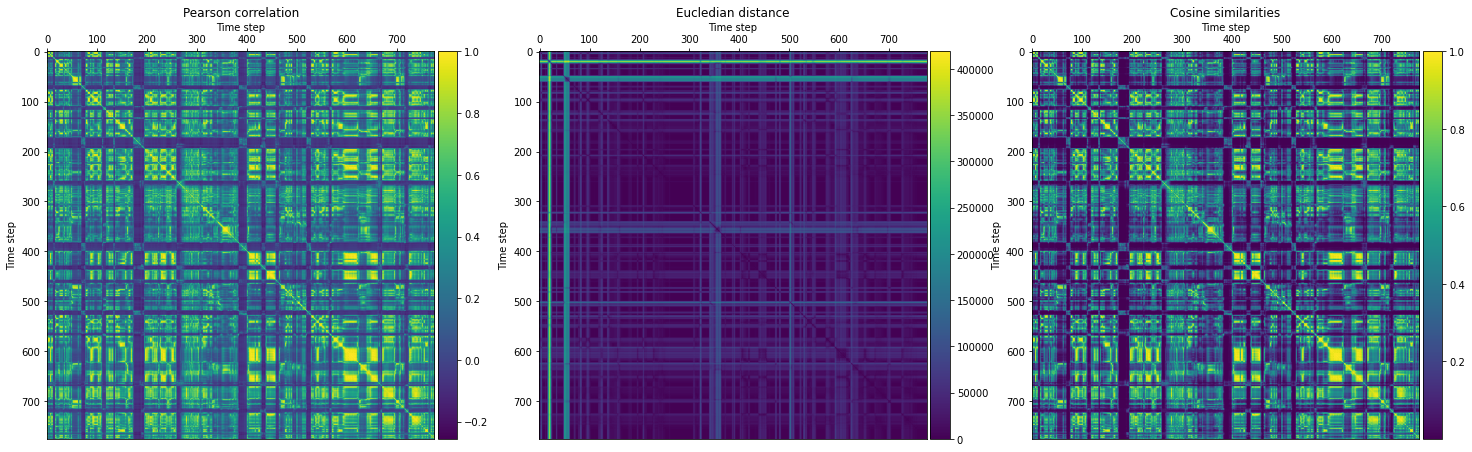

In [ ]:
fig = plt.figure(figsize=(25,10))

ax1 = plt.subplot(1, 3, 1)
im1 = ax1.imshow(pearson_correlations)
plt.title('Pearson correlation')
plt.xlabel('Time step')
plt.ylabel('Time step')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax = cax)
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_ticks_position('top')

ax2 = plt.subplot(1, 3, 2)
im2 = ax2.imshow(eucledian_distances)
plt.title('Eucledian distance')
plt.xlabel('Time step')
plt.ylabel('Time step')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax = cax)
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_ticks_position('top')

ax3 = plt.subplot(1, 3, 3)
im3 =ax3.imshow(cosine_similarities)
plt.title('Cosine similarities')
plt.xlabel('Time step')
plt.ylabel('Time step')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax = cax)
ax3.xaxis.set_label_position('top')
ax3.xaxis.set_ticks_position('top')

plt.show()


In [ ]:
text = 'would take approximately twenty months to implement and require expenditures of approximately three million dollars during that period.'
print(text)
print(prepreocess_text(text)[0])
print(prepreocess_text(text)[1])
print('Number of clusters is: ', len(prepreocess_text(text)[1]))

would take approximately twenty months to implement and require expenditures of approximately three million dollars during that period.
would_take_aproximately_twenty_months_to_implement_and_require_expenditures_of_aproximately_thre_milion_dolars_during_that_period
[23, 15, 21, 12, 4, 0, 20, 1, 11, 5, 0, 1, 16, 18, 15, 24, 9, 13, 1, 20, 5, 12, 25, 0, 20, 23, 5, 14, 20, 25, 0, 13, 15, 14, 20, 8, 19, 0, 20, 15, 0, 9, 13, 16, 12, 5, 13, 5, 14, 20, 0, 1, 14, 4, 0, 18, 5, 17, 21, 9, 18, 5, 0, 5, 24, 16, 5, 14, 4, 9, 20, 21, 18, 5, 19, 0, 15, 6, 0, 1, 16, 18, 15, 24, 9, 13, 1, 20, 5, 12, 25, 0, 20, 8, 18, 5, 0, 13, 9, 12, 9, 15, 14, 0, 4, 15, 12, 1, 18, 19, 0, 4, 21, 18, 9, 14, 7, 0, 20, 8, 1, 20, 0, 16, 5, 18, 9, 15, 4]
Number of clusters is:  129


In [ ]:
sample_rate, samples = wavfile.read('data/LJ047-0130.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
spectrogram = np.transpose(spectrogram)
print('sample_rate>', sample_rate)
print('samples>', len(samples))
print('frequencies>', len(frequencies))
print('times>', len(times))
print('-'*50)

sample_rate, samples = wavfile.read('data/LJ050-0222.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
spectrogram = np.transpose(spectrogram)
print('sample_rate>', sample_rate)
print('samples>', len(samples))
print('frequencies>', len(frequencies))
print('times>', len(times))
print('-'*50)

sample_rate, samples = wavfile.read('data/LJ050-0223.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=100)
spectrogram = np.transpose(spectrogram)
print('sample_rate>', sample_rate)
print('samples>', len(samples))
print('frequencies>', len(frequencies))
print('times>', len(times))
print('-'*50)

sample_rate, samples = wavfile.read('data/reda_test.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
spectrogram = np.transpose(spectrogram)
print('sample_rate>', sample_rate)
print('samples>', len(samples))
print('frequencies>', len(frequencies))
print('times>', len(times))
print('-'*50)



sample_rate> 22050
samples> 93597
frequencies> 129
times> 417
--------------------------------------------------
sample_rate> 22050
samples> 173981
frequencies> 129
times> 776
--------------------------------------------------
sample_rate> 22050
samples> 210589
frequencies> 51
times> 2392
--------------------------------------------------
sample_rate> 48000
samples> 1455040
frequencies> 51
times> 16534
--------------------------------------------------


# Building training data

In [4]:
df = pd.read_csv('LJSpeech-1.1/metadata.csv', sep='|', header=None)

X = []
Y_baseline = []

with tqdm(total=len(df)) as pbar:
    for index, row in df.iterrows():
        wave_file = 'LJSpeech-1.1/wavs/'+row[0]+'.wav'
        transcript = row[2]
        sample_rate, samples = wavfile.read(wave_file)
        frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=nperseg)
        spectrogram = np.transpose(spectrogram)
        out_indexes = prepreocess_text(transcript)[1]
        labels_baseline = get_labels_baseline(len(times), out_indexes)[0]
        
        X.append(spectrogram)
        Y_baseline.append(labels_baseline)

        pbar.update(1)
        
del df

100%|██████████| 13100/13100 [01:38<00:00, 132.94it/s]


In [5]:
def pad_sequences(sequences, maxlen):
    if isinstance(sequences[0][0], np.ndarray):
        pad_vec = [0]*len(sequences[0][0])
    else:
        pad_vec = 0
    pad_sequences = []
    with tqdm(total=len(sequences)) as pbar:
        for seq in sequences:
            seq = list(seq)
            if len(seq) > maxlen:
                seq = seq[0:maxlen]
            else:
                while len(seq) < maxlen:                
                    seq.insert(0, pad_vec)
            pad_sequences.append(seq)
            pbar.update(1)
    return np.array(pad_sequences)


In [6]:
input_sequences_X = pad_sequences(X, maxlen)
output_sequences_Y_baseline = pad_sequences(Y_baseline, maxlen)

x_train, x_eval, y_train, y_eval = train_test_split(input_sequences_X, 
                                                    output_sequences_Y_baseline, 
                                                    test_size=0.3, 
                                                    random_state=0)


# x_train = input_sequences_X[0:-3000]
# y_train = output_sequences_Y_baseline[0:-3000]

# x_eval = input_sequences_X[-3000:]
# y_eval = output_sequences_Y_baseline[-3000:]

print('Size of x_train>' ,len(x_train))
print('Size of x_eval>' ,len(x_eval))

del input_sequences_X
del output_sequences_Y_baseline


100%|██████████| 13100/13100 [00:00<00:00, 39590.77it/s]


Size of x_train> 9170
Size of x_eval> 3930


In [7]:
def create_model(dropout_value,learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(maxlen, len(x_train[0][0]))))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))
    model.add(Dense(len(vocabulary_to_index), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=RMSprop(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    return model
    
# #Print details of the model.
model = create_model(0.2,0.001)
model.summary()
# plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 512, 512)          790528    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512, 512)          1574912   
_________________________________________________________________
dense (Dense)                (None, 512, 27)           13851     
Total params: 2,379,291
Trainable params: 2,379,291
Non-trainable params: 0
_________________________________________________________________


In [8]:
class Test(keras.callbacks.Callback):
  def __init__(self, x_eval, y_eval):
    self.x_eval = x_eval
    self.y_eval = y_eval

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 10 == 0:
      i = randrange(len(self.x_eval))
      pred = self.model.predict(np.array([self.x_eval[i]]))
      pred = np.argmax(pred[0],axis=1)
      print('-'*20)
      text = '_'
      for v in self.y_eval[i]:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
      print(text)
      text = '_'
      for v in pred:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
      print(text)



In [9]:
test1 = Test(x_train, y_train)
test2 = Test(x_eval, y_eval)

model = create_model(0,0.001)
history = model.fit(x_train, 
                    y_train,
                    validation_data=(x_eval, y_eval),
                    epochs=100, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[test1, test2]
                    )


Epoch 1/100
18/18 [==============================] - 30s 1s/step - loss: 2.8262 - accuracy: 0.1974 - val_loss: 2.6092 - val_accuracy: 0.2343
--------------------
_a_leter_which_aforded_an_aditional_clue_was_also_found_in_the_pocket_of_th
_t_t_t_s_s
--------------------
_after_mixing_your_bread_in_the_morning_either_with_sponge_or_with_yeast_divide_the_kne
_at_s_n_st_tn_n_
Epoch 2/100
18/18 [==============================] - 18s 1s/step - loss: 2.6135 - accuracy: 0.2229 - val_loss: 2.5991 - val_accuracy: 0.2377
Epoch 3/100
18/18 [==============================] - 18s 1s/step - loss: 2.5972 - accuracy: 0.2273 - val_loss: 2.5762 - val_accuracy: 0.2394
Epoch 4/100
18/18 [==============================] - 18s 1s/step - loss: 2.5792 - accuracy: 0.2291 - val_loss: 2.5577 - val_accuracy: 0.2422
Epoch 5/100
18/18 [==============================] - 19s 1s/step - loss: 2.5592 - accuracy: 0.2376 - val_loss: 2.5414 - val_accuracy: 0.2403
Epoch 6/100
18/18 [==============================] - 19s 1s/s

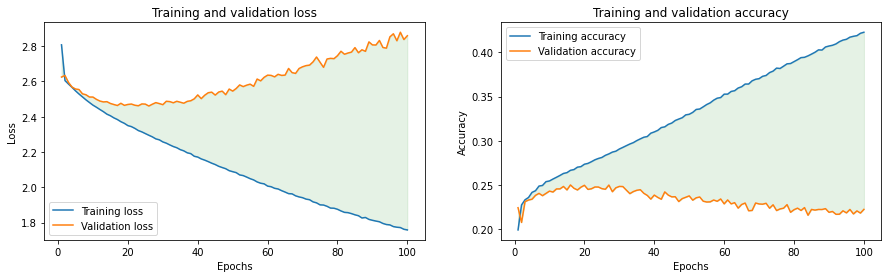

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
i = randrange(len(x_eval))
pred = model.predict(np.array([x_eval[i]]))
pred = np.argmax(pred[0],axis=1)
print('-'*20)
text = '_'
for v in y_eval[i]:
  if index_to_vocabulary[v] != text[-1]:
    text += index_to_vocabulary[v]
print(text)
text = '_'
for v in pred:
  if index_to_vocabulary[v] != text[-1]:
    text += index_to_vocabulary[v]
print(text)



--------------------
_that_the_oswalds_were_living_at_two_one_four_nely_stret_in_dalas
_th_aitctcl_thto_teo_i_n_e_eo_s_sf_f_he_tu_u_ertrtr_t_t_mi_ir_rcimiociohih_ththswi_m_sn_nsndamo_m_m_sim_eisiedtiehoeri_hihisworhvhfhvwhvhbvh_hegam_g_dmdeususou_at_a_ta_x_gyaman_mf_i_whut_atsinsidemck_ucesoaloenreroe_fo_leoetetretre_ft_ftestlylergce


# New algorithm

In [ ]:
print(len(times))
print(prepreocess_text(transcript)[1])
print(len(prepreocess_text(transcript)[1]))
print(prepreocess_text(transcript)[0])
# print(get_labels(times, prepreocess_text(transcript)[1]))

950
[16, 18, 9, 14, 20, 9, 14, 7, 0, 9, 14, 0, 20, 8, 5, 0, 15, 14, 12, 25, 0, 19, 5, 14, 19, 5, 0, 23, 9, 20, 8, 0, 23, 8, 9, 3, 8, 0, 23, 5, 0, 1, 18, 5, 0, 1, 20, 0, 16, 18, 5, 19, 5, 14, 20, 0, 3, 15, 14, 3, 5, 18, 14, 5, 4, 0, 4, 9, 6, 5, 18, 19, 0, 6, 18, 15, 13, 0, 13, 15, 19, 20, 0, 9, 6, 0, 14, 15, 20, 0, 6, 18, 15, 13, 0, 1, 12, 0, 20, 8, 5, 0, 1, 18, 20, 19, 0, 1, 14, 4, 0, 3, 18, 1, 6, 20, 19, 0, 18, 5, 16, 18, 5, 19, 5, 14, 20, 5, 4, 0, 9, 14, 0, 20, 8, 5, 0, 5, 24, 8, 9, 2, 9, 20, 9, 15, 14]
147
printing_in_the_only_sense_with_which_we_are_at_present_concerned_difers_from_most_if_not_from_al_the_arts_and_crafts_represented_in_the_exhibition


In [ ]:
def get_labels_EM(time_len, clusters):
    # Initialization
    cluster_assignements = []
    w = int(len(times) / len(clusters)) + 1
    i = 0
    for c in clusters:
        cluster_assignements.append([i] * w)
        i += 1
    print((len(cluster_assignements)-1)*w +len(cluster_assignements[-1]))
    print(time_len)
    while (len(cluster_assignements)-1)*w +len(cluster_assignements[-1])  < time_len:
        cluster_assignements[-1].append(cluster_assignements[-1][-1])
    # labels[0:len(times)]
    # Expectation-Maximization





    return cluster_assignements


In [ ]:
print(get_labels_EM(len(times), prepreocess_text(transcript)[1]))

840
878
[[0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4], [5, 5, 5, 5, 5, 5], [6, 6, 6, 6, 6, 6], [7, 7, 7, 7, 7, 7], [8, 8, 8, 8, 8, 8], [9, 9, 9, 9, 9, 9], [10, 10, 10, 10, 10, 10], [11, 11, 11, 11, 11, 11], [12, 12, 12, 12, 12, 12], [13, 13, 13, 13, 13, 13], [14, 14, 14, 14, 14, 14], [15, 15, 15, 15, 15, 15], [16, 16, 16, 16, 16, 16], [17, 17, 17, 17, 17, 17], [18, 18, 18, 18, 18, 18], [19, 19, 19, 19, 19, 19], [20, 20, 20, 20, 20, 20], [21, 21, 21, 21, 21, 21], [22, 22, 22, 22, 22, 22], [23, 23, 23, 23, 23, 23], [24, 24, 24, 24, 24, 24], [25, 25, 25, 25, 25, 25], [26, 26, 26, 26, 26, 26], [27, 27, 27, 27, 27, 27], [28, 28, 28, 28, 28, 28], [29, 29, 29, 29, 29, 29], [30, 30, 30, 30, 30, 30], [31, 31, 31, 31, 31, 31], [32, 32, 32, 32, 32, 32], [33, 33, 33, 33, 33, 33], [34, 34, 34, 34, 34, 34], [35, 35, 35, 35, 35, 35], [36, 36, 36, 36, 36, 36], [37, 37, 37, 37, 37, 37], [38, 38, 38, 38, 38, 38], [39, 39, 39, 39, 39, 39], [40, 40, 40

In [ ]:
0 : sim(0,C_0), sim(0,C_1)
1 : sim(1,C_0), sim(1,C_1)



In [ ]:
len(prepreocess_text(transcript)[1])

140

In [ ]:
len(times)

878

In [ ]:
878/140

6.271428571428571

In [ ]:
7*140

980